In [169]:
import matplotlib.pyplot as plt
import numpy as np

import torch,torchvision
from torch.utils.data import DataLoader,TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms

In [210]:
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True)

data=trainset.data
data=data.to(dtype=torch.float32)
norm = transforms.Normalize((128,),(128,))
data=norm(data)

data_target=trainset.targets.to(dtype=torch.float32)
#data_target
data=data.view(60000,1,28,28)
data=data.to(dtype=torch.float32)
#data_target=data_target.view(60000,1,28,28)

trainset=TensorDataset(data,data)
trainloader=DataLoader(trainset,batch_size=128,shuffle=True)

In [201]:
# Transformations
transform = transforms.Compose([transforms.ToTensor(),transform.])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128,shuffle=False)

In [171]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [172]:
def masker(shape,type='B'):
  mask=torch.ones(shape,shape)
  out,inn=mask.shape
  stride=inn/out
  mid=(out+1)//2
  mask[mid:,:]=0
  if type=='A':
    mask[mid-1,mid-1:]=0
  else:
    mask[mid-1,mid:]=0
  return mask
x=torch.ones(5,5)
#masker(5)

In [173]:
conv=nn.Conv2d(2,5,3)
mask=conv.weight.data
mask.shape
#mask[:,:,height//2,width//2:] = 0

torch.Size([5, 2, 3, 3])

In [174]:
class Maskcnn(nn.Module):
  def __init__(self,in_channels,out_channels,kernel,padding=0,stride=1,bias='True',types='B'):
    super(Maskcnn,self).__init__()
    self.conv=nn.Conv2d(in_channels,out_channels,kernel,padding=padding,stride=stride,bias=bias)
    self.mask1=masker(kernel,types).to(get_device())
    self.register_buffer('mask',self.mask1)

  def forward(self,x):
    self.conv.weight.data*=self.mask
    return (self.conv(x))

'''x=torch.ones(1,28,28)
c=Maskcnn(1,3,7,padding=3)
x=c(x)
x,x.shape'''

'x=torch.ones(1,28,28)\nc=Maskcnn(1,3,7,padding=3)\nx=c(x)\nx,x.shape'

In [175]:
class Pixelcnn(nn.Module):
  def __init__(self):
    super(Pixelcnn,self).__init__()
    self.conv1=Maskcnn(1,64,7,padding=3,types='A')
    self.conv2=Maskcnn(64,64,7,padding=3,types='B')
    self.conv3=Maskcnn(64,64,7,padding=3,types='B')
    self.conv4=Maskcnn(64,64,7,padding=3,types='B')
    self.conv5=Maskcnn(64,64,7,padding=3,types='B')
    self.conv6=Maskcnn(64,64,7,padding=3,types='B')
    self.conv7=nn.Conv2d(64,64,1,padding=0)
    self.conv8=nn.Conv2d(64,256,1,padding=0)
    self.bn1=nn.BatchNorm2d(64)
    self.bn2=nn.BatchNorm2d(64)
    self.bn3=nn.BatchNorm2d(64)
    self.bn4=nn.BatchNorm2d(64)
    self.bn5=nn.BatchNorm2d(64)
    self.bn6=nn.BatchNorm2d(64)
    self.bn7=nn.BatchNorm2d(64)
    self.bn=nn.BatchNorm2d(64)

  def forward(self,x):
    x=F.gelu(self.bn1(self.conv1(x)))
    x=F.gelu(self.bn2(self.conv2(x)))
    x=F.gelu(self.bn3(self.conv3(x)))
    x=F.gelu(self.bn4(self.conv4(x)))
    x=F.gelu(self.bn5(self.conv5(x)))
    x=F.gelu(self.bn6(self.conv6(x)))
    x=F.gelu(self.bn7(self.conv7(x)))
    x=self.conv8(x)
    return x

In [176]:
n=28
x=F.sigmoid(torch.randn(1,n,n))
y=x
x=x.view(n*n)
criterion=nn.BCELoss()
criterion(x,x),criterion(y,y)

(tensor(0.6008), tensor(0.6008))

In [177]:
lr_rate=0.001
epochs=100
model=Pixelcnn()
model.to(get_device())
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=lr_rate)

In [238]:
loss_list=[]
for epoch in range(epochs):
  total_loss=0
  length=0
  for data in train_loader:
    inputs, _ = data
    inputs=input.to(get_device())
    outputs = model((inputs))
    outputs = outputs.permute(0, 2, 3, 1).contiguous().view(-1, 256)
    targets = inputs.view(-1).long()
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()
    length+=1
  print(f'total_loss ={total_loss},avg_loss={total_loss/length},epoch={epoch}')

total_loss =522.7093974351883,avg_loss=1.1145189710771606,epoch=0
total_loss =424.7000133395195,avg_loss=0.9055437384637942,epoch=1
total_loss =392.97393107414246,avg_loss=0.8378975076207729,epoch=2
total_loss =376.7310221195221,avg_loss=0.8032644394872539,epoch=3
total_loss =366.3674341440201,avg_loss=0.781167236980853,epoch=4
total_loss =357.1520482301712,avg_loss=0.7615182265035634,epoch=5


KeyboardInterrupt: 

In [ ]:
data1=data[:128].view(128,28,28,1)
data1=data1.expand(-1, -1, -1, 256)
data1

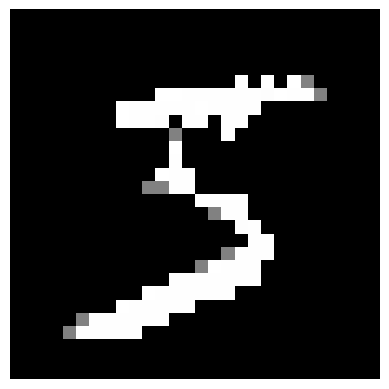

In [242]:
model.eval()
with torch.no_grad():
  x=train_dataset.data[:128].to(dtype=torch.float32)
  x=x.to('cuda:0')
  x=x.view(128,1,28,28)
  #print(x[0])

  x=model(x)
  x = x.permute(0, 2, 3, 1).contiguous().view(-1, 256)
  #print(x.shape,x[2])
  x=x.view(128,28,28,256)
  x=torch.argmax(x,dim=-1)

    #print(x[28*14:28*15])

  x=x[0].view(28,28)
  x=x.to('cpu')
  image_np = x.numpy()



  # Display the image using matplotlib
  plt.imshow(image_np, cmap='gray')  # 'gray' colormap is used for grayscale images
  plt.axis('off')  # Turn off axis labels
  plt.show()

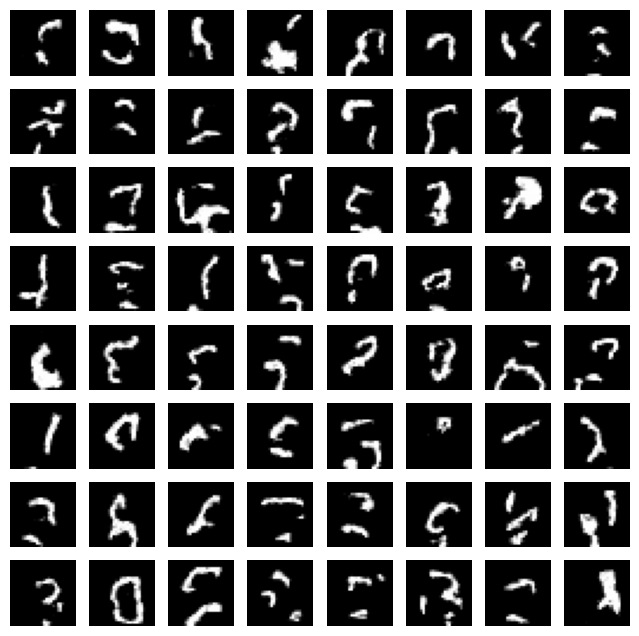

In [247]:
x = torch.zeros(64, 1, 28, 28)
#x = 2 * x - 1
x=x.to(get_device())
model.eval()
n=584

with torch.no_grad():
    for i in range(28):
        for j in range(28):
            out = model(x)
            #out=out.view(64,28,28,256)
            probs = F.softmax(out[:,:,i,j], dim=-1).data
            print(probs)
            x[:,:,i,j] = torch.multinomial(probs, 1).float()

x = x[:64].view(8, 8, 28, 28)
x = x.to('cpu')
image_np = x.numpy()

# Create a figure and a set of subplots arranged in an 8x8 grid
fig, axes = plt.subplots(8, 8, figsize=(8, 8))

# Iterate through the subplots and display each image
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(image_np[i, j], cmap='gray')
        axes[i, j].axis('off')  # Turn off axis labels

plt.show()

In [ ]:
model.eval()
with torch.no_grad():
  x=torch.zeros(1,28,28)
  #z=z.to('cuda:0')
  x=x.to(get_device())
  y=torch.zeros(1,28,28)
  y=y.to(get_device())
  k=24
  y[:k,:k]=data[9,:k,:k]
  for i in range(k,28):
    for j in range(k,28):
        y[0,i,j]=x[0,i,j]
        #print(y[:i])
        x=F.sigmoid(model(y))
        if i*j<780:
            x=torch.bernoulli(x.float())
        #print(x[:i])
        x=2*x-1
        #x=torch.bernoulli(x.float())

x=0.5*x+0.5
x=x.view(28,28)
x=x.to('cpu')
image_np = x.numpy()

# Display the image using matplotlib
plt.imshow(image_np, cmap='gray')  # 'gray' colormap is used for grayscale images
plt.axis('off')  # Turn off axis labels
plt.show()


In [ ]:
model.eval()
with torch.no_grad():
  x=torch.zeros(1,28,28)
  z=torch.zeros(784)
  #z=z.to('cuda:0')
  x=x.to('cuda:0')
  y=torch.zeros(1,28,28)
  y=y.to('cuda:0')
  for i in range(28):
    for j in range(28):
      y[0,i,j]=x[0,i,j]
      x=F.sigmoid(model(y))
      if i*j<182:
        x=torch.bernoulli(x.float())
      x=2*x-1
      #x=torch.bernoulli(x.float())
x=x.view(28,28)
x=x*0.5+0.5
#y=data[130]
#y=y.view(1,1,28,28)
#y=y.to('cuda:0')
#x=model(y)
#x=x[0]
x=x.to('cpu')
image_np = x.detach().numpy()

# Display the image using matplotlib
plt.imshow(image_np, cmap='gray')  # 'gray' colormap is used for grayscale images
plt.axis('off')  # Turn off axis labels
plt.show()